In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [ ]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [ ]:
colonnes_montant = ["DEDUPLI", "IDENT", "SommeDeMONTANT_NUM", "Flag_Top_Montant", "NovosScore_Vingtile"]

data_montant_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/DONS_FDF_N_TODAY_1ers_gestes_REF_MD.txt", sep=";", header = 0, low_memory=False, dtype=str) #, dtype=str )#, dtype='Int64')

data_montant_orig.iloc[:,2]=data_montant_orig.iloc[:,2].str.replace(",",".")

data_montant_orig.columns =colonnes_montant
data_montant_orig["SommeDeMONTANT_NUM"]=data_montant_orig["SommeDeMONTANT_NUM"].astype(float)

In [ ]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_8_new_my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, dtype=str)#, dtype='Int64')


In [ ]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1192180, 23)

In [ ]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,0010000001,02,81,08,91,09,06,21,21,01,71,41,07,04,12,04,20,02,02,01,51,05,1
1,0010000006,01,75,07,43,04,06,06,13,02,71,64,07,06,12,09,04,12,04,13,12,01,1
2,0010000011,01,76,07,43,04,06,06,16,03,54,81,05,08,07,12,06,06,04,18,36,03,2
3,0010000013,03,75,07,43,04,04,06,13,01,71,36,07,03,12,11,11,19,04,06,21,02,1
4,0010000015,02,33,03,44,04,06,07,12,01,71,42,07,04,12,05,14,03,03,01,14,01,2


In [ ]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    colonnes = tableau_corr.columns
    val_temp = 0 
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
                val_temp += 1

            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
                val_temp += 1
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0
    if val_temp == 0:
        print("IL N'Y A PAS DE CORRELATION ENTRE LES VARIABLES PAR RAPPORT AU SEUIL PRIS")
        


def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    #model.fit(X_train, y_train)
    y_pred_test = (model.predict(X_test) > 0.5).astype("int64").ravel()
    y_pred_train = (model.predict(X_train) > 0.5 ).astype("int64").ravel()

    y_pred_test = np.where(y_pred_test==0, 2, y_pred_test) 
    y_pred_train = np.where(y_pred_train==0, 2, y_pred_train) 

    y_test = np.where(y_test==0, 2, y_test) 
    y_train = np.where(y_train==0, 2, y_train) 

    print("test",accuracy_score(y_test, y_pred_test)); print("train", accuracy_score(y_train, y_pred_train))

    print("test set : ")
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test)) 
    print("train set : ")
    print(confusion_matrix(y_train, y_pred_train )) # ajouter 
    print(classification_report(y_train, y_pred_train ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def vingtiles(model, data_orig, affichage, save, path): # data_orig est une variables locale (peut être différente au df d'origine)
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe Top_mon)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # vingtiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    #print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)

    # création de la dernière colonne CLASSE et son remplissage
    index_20_ord = pd.DataFrame(np.unique(df_tous["TRANCHES"])) 
    df_tous["CLASSE"]=df_tous["TRANCHES"].copy()
    ind_val=1
    for kk in range(20):
        df_tous["CLASSE"][df_tous["CLASSE"]== index_20_ord.iloc[kk,0] ] = str(ind_val) 
        ind_val+=1
    print(df_tous)    
    
    # pour la colonne Top_mon : changement de type de variable et remplissage des valeurs (s'il le faut)
    data_temp_t = data_orig.copy()
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t #data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne TOTAL
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

    return  df_tous


def tableau_5_montant(df_tous, data_montant_orig, affichage, save, path):
    # tableau avec les deux variables qui nous intéressent
    ident_et_montant = data_montant_orig[["IDENT","SommeDeMONTANT_NUM"]]

    # jointure
    tableau_resultats_et_montant = pd.merge(df_tous,ident_et_montant)
    #print(tableau_resultats_et_montant) 

    # on élimine toutes les sommes supérieur à 5000 €
    tableau_resultats_et_montant = tableau_resultats_et_montant[tableau_resultats_et_montant["SommeDeMONTANT_NUM"] <= 5000]
    print(tableau_resultats_et_montant) 
    #print(tableau_resultats_et_montant["TRANCHES"].value_counts())
    #print(pd.DataFrame(np.unique(tableau_resultats_et_montant["TRANCHES"])))

    # index
    index_temp = pd.DataFrame(np.unique(tableau_resultats_et_montant["TRANCHES"])) 

    # création du tableau qui contiendra les résultats finaux
    tableau_resultats_finaux = pd.DataFrame(columns=["TRANCHES","Moyen_Somme","TOTAL"],index=range(20))
    tableau_resultats_finaux["TRANCHES"] = index_temp

    # remplissage du tableau final
    for k in range(20):
        tableau_resultats_finaux.iloc[k,1] = tableau_resultats_et_montant[tableau_resultats_et_montant["TRANCHES"]==index_temp.iloc[k,0]]["SommeDeMONTANT_NUM"].mean()
        tableau_resultats_finaux.iloc[k,2] = (tableau_resultats_et_montant["TRANCHES"]==index_temp.iloc[k,0]).sum()
    
    # affichage
    if affichage:        
        print(tableau_resultats_finaux)
    
    # enregistrement sous Excel
    if save:
        tableau_resultats_finaux.to_excel(path)


def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data
          


In [ ]:

from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score

In [ ]:
###########################################################################################################
#                                                   KERAS 
###########################################################################################################


In [ ]:
##########################################
# SANS LES VARIABLES CORR  ET ENCODAGE DUMMIES
#########################################

In [ ]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F",
                "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])
train_Y_s[train_Y_s==2]=0
train_Y_s[train_Y_s==1]=1

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])
test_Y_s[test_Y_s==2]=0
train_Y_s[train_Y_s==1]=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
"""
import os
%env PYTHONHASHSEED=0
os.environ['PYTHONHASHSEED']=str(0)
"""
import tensorflow as tf
import random 
import keras
from keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.utils import class_weight 

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)


In [ ]:


# Create function returning a compiled network

def create_network(number_of_features):
    # numbers of features
    number_of_features = number_of_features  #train_X_s.shape[1]

    # start neural network
    network = models.Sequential()

    # add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=200, activation="relu", input_shape = (number_of_features, ), kernel_initializer=keras.initializers.glorot_uniform(seed=0) ))

    # add fully connected layer with a ReLu activation function
    network.add(layers.Dense(units=100, activation = "relu", kernel_initializer=keras.initializers.glorot_uniform(seed=0) ) )

    # add fully connected layer with a ReLu activation function
    network.add(layers.Dense(units=50, activation = "tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=0) ) )    

    # add fully connected layer with a ReLu activation function
    network.add(layers.Dense(units=20, activation = "tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=0) ) )    

    # add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation = "sigmoid", kernel_initializer=keras.initializers.glorot_uniform(seed=0) ) )

    # compile neural network
    network.compile(loss="binary_crossentropy", optimizer ="adam", metrics = ["accuracy","Recall"] )


    return network


In [ ]:
def plot_graphics(history):
    # get training and test loss histories
    training_loss = history.history["loss"]
    test_loss = history.history["val_loss"]

    # create count of the number of epochs
    epoch_count = range(1, len(training_loss)+1)

    # visualize loss history
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    #plt.figure(figsize=(8,5))
    plt.plot(epoch_count, training_loss, "r--" )
    plt.plot(epoch_count, test_loss, "b-")
    plt.legend(["Training Loss", "Test Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # get training and test accuracy histories
    training_accuracy = history.history["accuracy"]
    test_accuracy = history.history["val_accuracy"]

    plt.subplot(122)
    #plt.figure(figsize=(8,5))
    plt.plot(epoch_count, training_accuracy, "r--")
    plt.plot(epoch_count, test_accuracy, "b-")
    plt.legend(["Training Accuracy", "Test Accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy Score")

    # get training and test recall histories
    training_recall = history.history["recall"]
    test_recall = history.history["val_recall"]

    plt.figure(figsize=(8,5))
    plt.plot(epoch_count, training_recall, "r--")
    plt.plot(epoch_count, test_recall, "b-")
    plt.legend(["Training Recall", "Test Recall"])
    plt.xlabel("Epoch")
    plt.ylabel("Recall Score")


In [ ]:
# class weight for embalanced data
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_Y_s ),train_Y_s)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.684332948534606, 1: 1.8562415291863346}

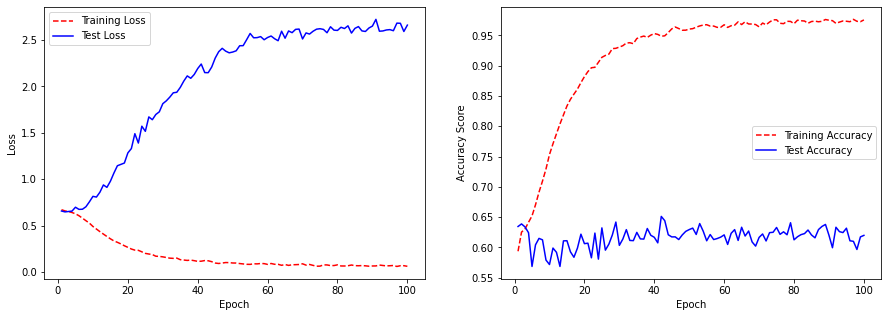

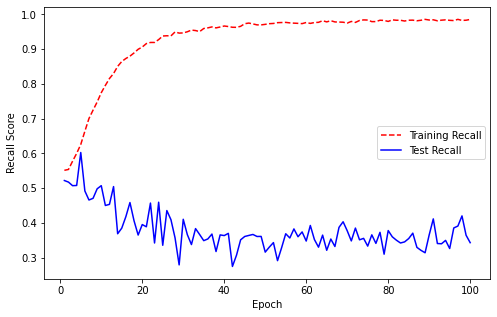

In [ ]:

# train neural network
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=100, verbose=0, batch_size=1024,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))

plot_graphics(history)

Epoch 1/20
78/78 [==============================] - 3s 22ms/step - loss: 0.6792 - accuracy: 0.5746 - recall: 0.5366 - val_loss: 0.6578 - val_accuracy: 0.6346 - val_recall: 0.5219
Epoch 2/20
78/78 [==============================] - 1s 17ms/step - loss: 0.6625 - accuracy: 0.6255 - recall: 0.5509 - val_loss: 0.6482 - val_accuracy: 0.6389 - val_recall: 0.5174
Epoch 3/20
78/78 [==============================] - 1s 16ms/step - loss: 0.6521 - accuracy: 0.6363 - recall: 0.5765 - val_loss: 0.6524 - val_accuracy: 0.6339 - val_recall: 0.5070
Epoch 4/20
78/78 [==============================] - 1s 17ms/step - loss: 0.6414 - accuracy: 0.6455 - recall: 0.5883 - val_loss: 0.6564 - val_accuracy: 0.6244 - val_recall: 0.5076
Epoch 5/20
78/78 [==============================] - 1s 17ms/step - loss: 0.6247 - accuracy: 0.6591 - recall: 0.6270 - val_loss: 0.6984 - val_accuracy: 0.5687 - val_recall: 0.6025
Epoch 6/20
78/78 [==============================] - 1s 17ms/step - loss: 0.6016 - accuracy: 0.6786 - reca

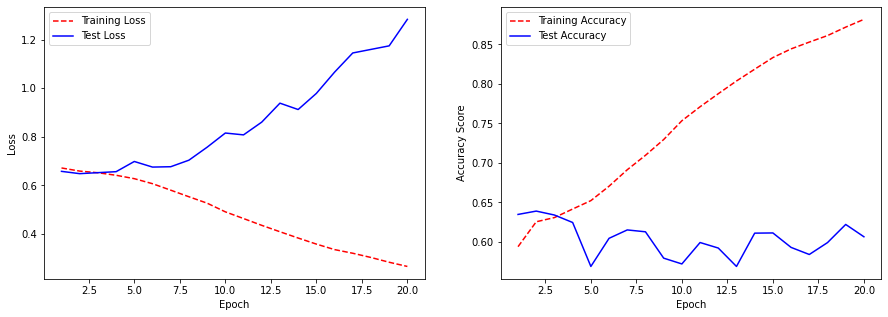

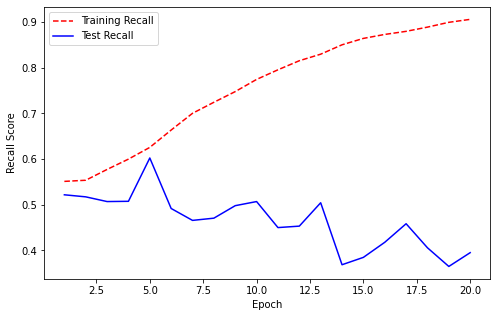

In [ ]:
# 
# train neural network
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=20, verbose=1, batch_size=1024,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))

plot_graphics(history)

In [ ]:
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=3, verbose=1, batch_size=1024,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))

evaluation(network, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall", plot=False)

Epoch 1/3
78/78 [==============================] - 3s 22ms/step - loss: 0.6792 - accuracy: 0.5746 - recall: 0.5366 - val_loss: 0.6578 - val_accuracy: 0.6346 - val_recall: 0.5219
Epoch 2/3
78/78 [==============================] - 1s 17ms/step - loss: 0.6625 - accuracy: 0.6255 - recall: 0.5509 - val_loss: 0.6482 - val_accuracy: 0.6389 - val_recall: 0.5174
Epoch 3/3
78/78 [==============================] - 1s 17ms/step - loss: 0.6521 - accuracy: 0.6363 - recall: 0.5765 - val_loss: 0.6524 - val_accuracy: 0.6339 - val_recall: 0.5070
test 0.6338872104733132
train 0.6685759605216778
test set : 
[[2703 2628]
 [4643 9886]]
              precision    recall  f1-score   support

           1       0.37      0.51      0.43      5331
           2       0.79      0.68      0.73     14529

    accuracy                           0.63     19860
   macro avg       0.58      0.59      0.58     19860
weighted avg       0.68      0.63      0.65     19860

train set : 
[[11952  9445]
 [16882 41157]]
       

In [ ]:
# TRAIN SET TEST SET
vingtiles_tableau = vingtiles(model= network, data_orig= data, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_Keras.xlsx")

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


            IDENT     PROBA
11693  0010258609  0.126862
41055  0010366143  0.130012
74064  0010408461  0.134818
76031  0010410997  0.136140
34269  0010358714  0.141950
...           ...       ...
5615   0010208685  0.931033
5627   0010211298  0.931033
29590  0010349653  0.931033
83536  0010503920  0.933807
93101  0010530839  0.936364

[99296 rows x 2 columns]
0.919820    49
0.713750    26
0.666592    24
0.761434    19
0.742478    19
            ..
0.458809     1
0.488790     1
0.582007     1
0.726014     1
0.500001     1
Name: PROBA, Length: 96170, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


            IDENT     PROBA        TRANCHES CLASSE
11693  0010258609  0.126862   (0.126, 0.28]      1
41055  0010366143  0.130012   (0.126, 0.28]      1
74064  0010408461  0.134818   (0.126, 0.28]      1
76031  0010410997  0.136140   (0.126, 0.28]      1
34269  0010358714  0.141950   (0.126, 0.28]      1
...           ...       ...             ...    ...
5615   0010208685  0.931033  (0.716, 0.936]     20
5627   0010211298  0.931033  (0.716, 0.936]     20
29590  0010349653  0.931033  (0.716, 0.936]     20
83536  0010503920  0.933807  (0.716, 0.936]     20
93101  0010530839  0.936364  (0.716, 0.936]     20

[99296 rows x 4 columns]
Top_mon            1     2  TOTAL
TRANCHES                         
(0.126, 0.28]    425  4540   4965
(0.28, 0.312]    604  4361   4965
(0.312, 0.335]   669  4296   4965
(0.335, 0.355]   756  4209   4965
(0.355, 0.373]   841  4123   4964
(0.373, 0.39]    929  4036   4965
(0.39, 0.406]    955  4010   4965
(0.406, 0.422]  1054  3911   4965
(0.422, 0.438]  1103  

In [ ]:
# TABLEAU MONTANT
tableau_5_montant(vingtiles_tableau, data_montant_orig, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/montant_Neural_Net.xlsx")

            IDENT     PROBA        TRANCHES CLASSE  SommeDeMONTANT_NUM
0      0010258609  0.126862   (0.126, 0.28]      1                20.0
1      0010366143  0.130012   (0.126, 0.28]      1                20.0
2      0010408461  0.134818   (0.126, 0.28]      1                15.0
3      0010410997  0.136140   (0.126, 0.28]      1                20.0
4      0010358714  0.141950   (0.126, 0.28]      1                20.0
...           ...       ...             ...    ...                 ...
99290  0010502100  0.931033  (0.716, 0.936]     20                50.0
99291  0010208685  0.931033  (0.716, 0.936]     20              5000.0
99292  0010211298  0.931033  (0.716, 0.936]     20              3000.0
99293  0010349653  0.931033  (0.716, 0.936]     20                20.0
99295  0010530839  0.936364  (0.716, 0.936]     20               200.0

[99146 rows x 5 columns]
          TRANCHES Moyen_Somme TOTAL
0    (0.126, 0.28]     24.6402  4964
1    (0.28, 0.312]     27.0631  4965
2   (0.312,

In [ ]:
2905/4965

0.5850956696878147

In [ ]:

#k-fold cross-validation neural networks ( FOR SMALLER DATA )

# wrap Keras model so it can be used by scikit-learn 
neural_network = KerasClassifier(build_fn =lambda:create_network(number_of_features=train_X_s.shape[1]), epochs=3, batch_size=1024, verbose=0)

# evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, train_X_s, train_Y_s, cv = 5, n_jobs=2, scoring="accuracy")



array([0.7413142 , 0.73966136, 0.73361868, 0.73311513, 0.73871719])

In [ ]:
""""
# wrap keras model 
neural_network = KerasClassifier(build_fn = create_network, verbose =0)

# create hyperparameters 
hyperparameters = {optimizer = ["rmsprop", "adam"] , epochs = [5, 10], batch_size = [5, 10, 100]   }

grid = GridSearchCV(estimator = neural_network, param_grid=hyperparameters)

result = grid.fit( , )

result.best_params_
""""

In [ ]:
###########################################################################################################"
#                                              VINGTILES LOUIS
###########################################################################################################

In [ ]:
colonnes_louis=["IDENT","Top_mon","predic_mon_top","prob_mon_top","SommeDeMONTANT_NUM","CLASSE_NN_L"]

tableau_louis = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/result_with_iden_monant_louis.csv", sep= ";", header = 0, names=colonnes_louis, low_memory=False, dtype=str )#, dtype='Int64')

In [ ]:
def vingtiles_louis(tableau_proba_louis, data_orig, affichage, save, path): # data_orig est une variables locale (peut être différente au df d'origine)
    # model éliminé
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe Top_mon)
    #tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])

    #df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    df_tous = pd.DataFrame({'IDENT': tableau_proba_louis["IDENT"] , 'PROBA':tableau_louis["predic_mon_top"].astype(float) })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # vingtiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    #print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)

    # création de la dernière colonne CLASSE et son remplissage
    index_20_ord = pd.DataFrame(np.unique(df_tous["TRANCHES"])) 
    df_tous["CLASSE"]=df_tous["TRANCHES"].copy()
    ind_val=1
    for kk in range(20):
        df_tous["CLASSE"][df_tous["CLASSE"]== index_20_ord.iloc[kk,0] ] = str(ind_val) 
        ind_val+=1
    print(df_tous)   

    # pour la colonne Top_mon : changement de type de variable et remplissage des valeurs (s'il le faut)
    data_temp_t = data_orig.copy()
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t #data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats
    df_tous = pd.merge(df_tous, ident_class_tous)


    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne TOTAL
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

    return  df_tous




In [ ]:
# TRAIN SET TEST SET
vingtiles_tableau_louis = vingtiles_louis(tableau_louis, data_orig= data, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_louis_test.xlsx")

            IDENT     PROBA
0      0010375379  0.337496
1      0010337063  0.337583
2      0010398167  0.337589
3      0010259011  0.337646
4      0010402446  0.337655
...           ...       ...
99288  0010380785  0.801503
99289  0010260318  0.801503
99293  0010396372  0.801503
99294  0010099997  0.801831
99295  0010027306  0.802426

[99296 rows x 2 columns]
0.505172    668
0.354766    163
0.378716    143
0.636734    142
0.443627    133
           ... 
0.472959      1
0.428832      1
0.417283      1
0.417716      1
0.618935      1
Name: PROBA, Length: 93900, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


            IDENT     PROBA        TRANCHES CLASSE
0      0010375379  0.337496  (0.336, 0.366]      1
1      0010337063  0.337583  (0.336, 0.366]      1
2      0010398167  0.337589  (0.336, 0.366]      1
3      0010259011  0.337646  (0.336, 0.366]      1
4      0010402446  0.337655  (0.336, 0.366]      1
...           ...       ...             ...    ...
99288  0010380785  0.801503  (0.676, 0.802]     20
99289  0010260318  0.801503  (0.676, 0.802]     20
99293  0010396372  0.801503  (0.676, 0.802]     20
99294  0010099997  0.801831  (0.676, 0.802]     20
99295  0010027306  0.802426  (0.676, 0.802]     20

[99296 rows x 4 columns]
Top_mon            1     2  TOTAL
TRANCHES                         
(0.336, 0.366]   703  4262   4965
(0.366, 0.379]   854  4111   4965
(0.379, 0.393]   870  4096   4966
(0.393, 0.403]   922  4042   4964
(0.403, 0.413]  1002  3962   4964
(0.413, 0.422]  1083  3882   4965
(0.422, 0.432]  1076  3889   4965
(0.432, 0.445]  1105  3865   4970
(0.445, 0.462]  1184  

In [ ]:
# TABLEAU MONTANT
tableau_5_montant(vingtiles_tableau_louis, data_montant_orig, affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/montant_louis_test.xlsx")

            IDENT     PROBA        TRANCHES CLASSE  SommeDeMONTANT_NUM
0      0010375379  0.337496  (0.336, 0.366]      1                50.0
1      0010337063  0.337583  (0.336, 0.366]      1                15.0
2      0010398167  0.337589  (0.336, 0.366]      1                20.0
3      0010259011  0.337646  (0.336, 0.366]      1                10.0
4      0010402446  0.337655  (0.336, 0.366]      1                20.0
...           ...       ...             ...    ...                 ...
99291  0010380785  0.801503  (0.676, 0.802]     20                50.0
99292  0010260318  0.801503  (0.676, 0.802]     20                20.0
99293  0010396372  0.801503  (0.676, 0.802]     20                40.0
99294  0010099997  0.801831  (0.676, 0.802]     20                20.0
99295  0010027306  0.802426  (0.676, 0.802]     20                20.0

[99146 rows x 5 columns]
          TRANCHES Moyen_Somme TOTAL
0   (0.336, 0.366]     28.3548  4965
1   (0.366, 0.379]     30.4497  4961
2   (0.379,

In [ ]:
2539/4965, 2539/26728

(0.5113796576032226, 0.09499401376833283)

In [ ]:
vingtiles_tableau_louis

,IDENT,PROBA,TRANCHES,CLASSE,Top_mon
0,0010375379,0.337496,"(0.336, 0.366]",1,1
1,0010337063,0.337583,"(0.336, 0.366]",1,2
2,0010398167,0.337589,"(0.336, 0.366]",1,2
3,0010259011,0.337646,"(0.336, 0.366]",1,2
4,0010402446,0.337655,"(0.336, 0.366]",1,2
...,...,...,...,...,...
100007,0010380785,0.801503,"(0.676, 0.802]",20,1
100008,0010260318,0.801503,"(0.676, 0.802]",20,2
100009,0010396372,0.801503,"(0.676, 0.802]",20,2
100010,0010099997,0.801831,"(0.676, 0.802]",20,2
